#### Steps to setup Openbb SDK in Jupyter notebook

1. Check conda version

    $ conda --version 

2. Update conda recommended

    $ conda update -n base -c conda-forge conda

3. Setup and activate the `meta-labell` environment

    $ conda env create --file=environment.yaml

    $ conda activate meta-labell    

4. Install openbb sdk
    
    $ pip install "openbb" --no-cache-dir              

### Introduction 
This notebook studies fundamentals and price signals of common cryptocurrencies using the OpenBB SDK. We consider the universe of cryptos with at least a $ 100 Million USD market capitalization on Coinmarketcap.  

### Data
We use the OpenBB SDK to download the data from the OpenBB API. The data is stored in a local database. The data is updated daily. 

### Methods 
We begin with a simple forecasting model such as AutoArima and explore intra-day changes in volatility and prices. As part of our token selection process, we also use fundamental knowledge about each cryptocurrency, especially for newer tokens such as the number of developers on each project's Github, and the frequency of commits. 


In [1]:
%load_ext lineapy

In [2]:
import numpy as np
import pandas as pd
from openbb_terminal.sdk import openbb
from statsforecast.models import AutoARIMA
import requests
import re
import altair as alt
from scipy.linalg import svd
import lineapy

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
%matplotlib inline

# Turn off warnings and messages 
import warnings
warnings.filterwarnings('ignore')

START                                                                           
END                                                                             
START                                                                           
END                                                                             
START                                                                           
END                                                                             


Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Logging configuration finished                                                  
Logging set to ['file', 'posthog']                                              
Verbosity set to 20                                                             
LOGFORMAT:                                                                      
%(levelname)s-%(appName)s-%(commitHash)s-%(appId)s-%(sessionId)s-%(userId)s-%(as
ctime)s-%(name)s-%(funcName)s-%(lineno)s-%(message)s                            
STARTUP: {"PREFERENCES": {"PLOT_BACKEND": null, "PLOT_DPI": 100, "PLOT_HEIGHT": 
500, "PLOT_WIDTH": 800, "PLOT_HEIGHT_PERCENTAGE": 50.0, "PLOT_WIDTH_PERCENTAGE":
70.0, "PLOT_OPEN_EXPORT": false, "PLOT_ENABLE_PYWRY": true, "PLOT_PYWRY_WIDTH": 
1400, "PLOT_PYWRY_HEIGHT": 762, "FILE_OVERWRITE": false, "SHOW_VERSION": true,  
"RETRY_WITH_LOAD": false, "USE_TABULATE_DF": true, "USE_INTERACTIVE_DF": true,  
"USE_CLEAR_AFTER_CMD": false, "USE_DATETIME": true, "USE_PROMPT_TOOLKIT": true, 
"USE_PLOT_AUTOSCALING": fals

In [3]:
# Show trending coins
openbb.crypto.disc.trending()

START                                                                           
{"INPUT": {"chart": "False"}, "VIRTUAL_PATH": "crypto.disc.trending", "CHART":  
false}                                                                          
START                                                                           
END                                                                             
END                                                                             


,Symbol,Name,market_cap Cap Rank
0,bella-protocol,Bella Protocol,472
1,bonk,Bonk,932
2,gala,GALA,93
3,bitcoin,Bitcoin,1
4,trust-wallet-token,Trust Wallet,100
5,qanplatform,QANplatform,292
6,arbitrum,Arbitrum,43


In [4]:
btc_df = openbb.crypto.load(symbol="btc",to_symbol="usd",start_date="2019-01-01",source="YahooFinance")
eth_df = openbb.crypto.load(symbol="eth",to_symbol="usd",start_date="2019-01-01",source="YahooFinance")

# Combine btc and eth dataframes and save under /data. Append current date to the filename. 
# Add a new column identifying which coin the row belongs to. 
btc_df['coin'] = 'btc'
eth_df['coin'] = 'eth'
btc_eth_df = pd.concat([btc_df,eth_df],axis=0)

btc_eth_df.tail(5)

START                                                                           
{"INPUT": {"start_date": "2019-01-01", "interval": "1440", "exchange":          
"binance", "to_symbol": "usd", "end_date": "None", "source": "YahooFinance",    
"symbol": "btc", "chart": "False"}, "VIRTUAL_PATH": "crypto.load", "CHART":     
false}                                                                          
END                                                                             
START                                                                           
{"INPUT": {"start_date": "2019-01-01", "interval": "1440", "exchange":          
"binance", "to_symbol": "usd", "end_date": "None", "source": "YahooFinance",    
"symbol": "eth", "chart": "False"}, "VIRTUAL_PATH": "crypto.load", "CHART":     
false}                                                                          
END                                                                             


,Open,High,Low,Close,Adj Close,Volume,coin
date,,,,,,,
2023-09-07,1632.262817,1657.303711,1623.220459,1647.598267,1647.598267,4907290296,eth
2023-09-08,1647.807617,1657.136353,1617.796509,1636.137817,1636.137817,4598495496,eth
2023-09-09,1636.050415,1636.870728,1629.660889,1635.162354,1635.162354,2081625742,eth
2023-09-10,1635.211670,1635.433105,1604.040527,1616.828857,1616.828857,4339499949,eth
2023-09-11,1616.769775,1618.305786,1533.426758,1551.637695,1551.637695,7693700923,eth


In [5]:
# Save btc_eth_df as a csv file under /data
btc_eth_df.to_csv('data/btc_eth_df.csv')

In [6]:
lineapy.save(btc_eth_df, "data/btc_eth_df")

LineaArtifact(name='data/btc_eth_df', _version=1)

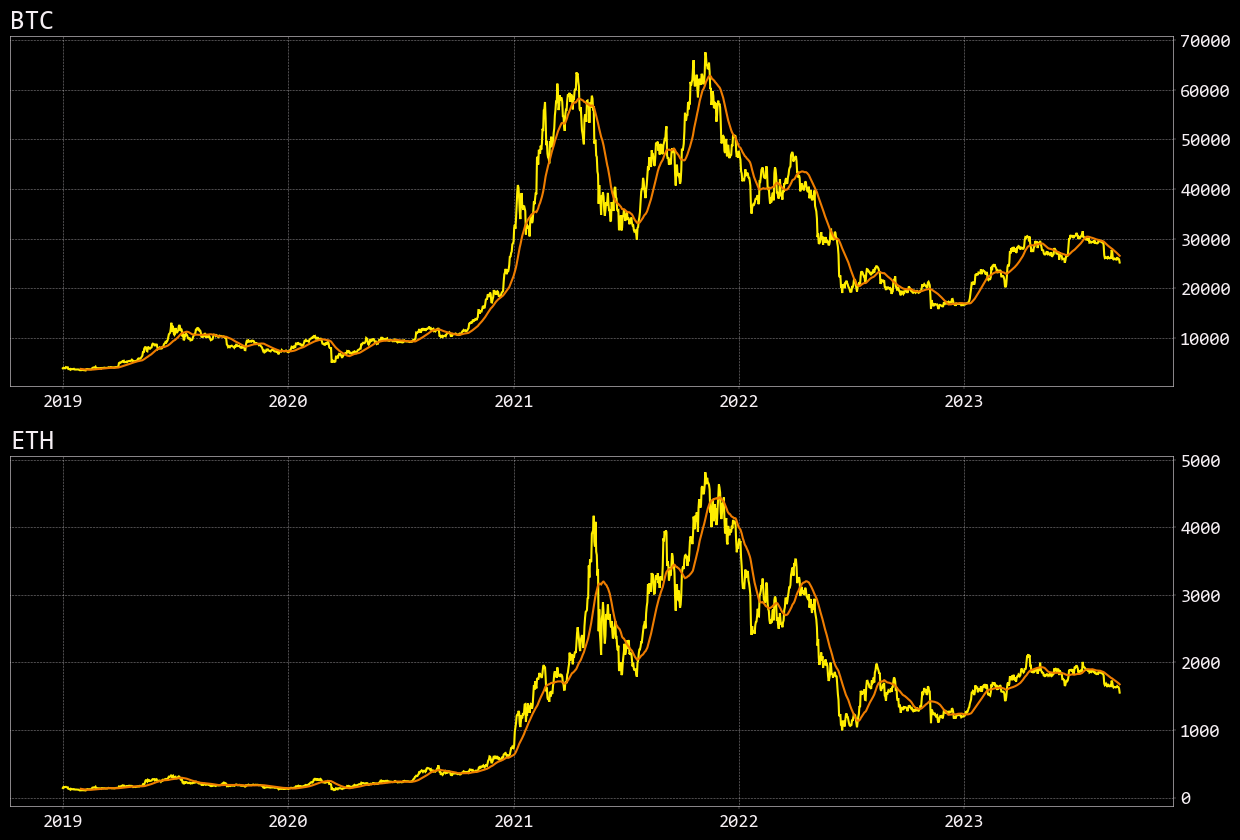

In [7]:
# Plot the Adj Close price overtime for BTC and ETH. 
# Use two separate subplots for BTC and ETH.
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the 30-day moving average for BTC and ETH
btc_df['MA'] = btc_df['Adj Close'].rolling(window=30).mean()
eth_df['MA'] = eth_df['Adj Close'].rolling(window=30).mean()

# Create subplots for BTC and ETH
fig, axes = plt.subplots(2,1,figsize=(15,10))

# Plot the Adj Close price and the moving average for BTC
axes[0].plot(btc_df['Adj Close'])
axes[0].plot(btc_df['MA'])
axes[0].set_title('BTC')

# Plot the Adj Close price and the moving average for ETH
axes[1].plot(eth_df['Adj Close'])
axes[1].plot(eth_df['MA'])
axes[1].set_title('ETH')

# Show the plots
plt.show()

### References 
Sean Taylor. Gas Price Forecast. https://github.com/seanjtaylor/gas-price-forecast